# Library Import

In [ ]:
!pip install --upgrade pip
!pip install numpy pandas scikit-learn tqdm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
### Library Import ###
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import sys

# 경고 무시 설정
import warnings
warnings.filterwarnings('ignore')

# 전처리

## 함수 정의

In [ ]:
######################################## 범주형 포함 버전 + 대푯값 변환 X #################################
# 삭제 및 변환 근거 EDA.py 참고
def preprocess_data(df_origin):

    df = df_origin.copy()

    # 절반 이상 결측치 칼럼, 단일값 칼럼, 결측치 포함 칼럼 제거
    drop_cols = [
        column for column in df.columns
        if (df[column].notnull().sum() // 2) < df[column].isnull().sum()
        or df[column].nunique() == 1
        or df[column].isnull().any()
    ]

    df_drop = df.drop(columns=drop_cols)

    # Workorder 제거
    work_to_drop = ['Workorder_Dam', 'Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2']
    df_drop = df_drop.drop(columns=work_to_drop)

    # palletID, Recip, Workmode 칼럼 삭제
    cols_to_drop = [col for col in df_drop.columns if any(keyword in col for keyword in ['PalletID', 'Receip', 'WorkMode'])]
    df_drop = df_drop.drop(columns=cols_to_drop)

    # model suffix values
    model_suffixe_value = ['AJX75334501', 'AJX75334503', 'AJX75334502', 'AJX75334505', 'AJX75334506', 'AJX75334507', 'AJX75334508']

    # one-hot encoding 추가
    for suffix in model_suffixe_value:
        df_drop[suffix] = ((df_drop['Model.Suffix_Dam'] == suffix) &
                                    (df_drop['Model.Suffix_Fill1'] == suffix) &
                                    (df_drop['Model.Suffix_Fill2'] == suffix) &
                                    (df_drop['Model.Suffix_AutoClave'] == suffix)).astype(int)

    # 'Model.Suffix - ' columns drop
    df_drop.drop(columns=['Model.Suffix_Dam', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2', 'Model.Suffix_AutoClave'], inplace=True)

    # Equipment 칼럼 더미화
    df_drop = pd.get_dummies(df_drop, columns=['Equipment_Dam', 'Equipment_Fill1', 'Equipment_Fill2'])

    # True / False -> 1 / 0
    df_drop = df_drop.applymap(lambda x: 1 if x is True else (0 if x is False else x))

    # 'Chamber Temp. Judge Value_AutoClave' 컬럼의 OK와 NG 값을 0과 1로 변환
    df_drop['Chamber Temp. Judge Value_AutoClave'] = df_drop['Chamber Temp. Judge Value_AutoClave'].replace({'OK': 0, 'NG': 1})


    # 전처리 완료

    # target 칼럼 마지막 배치
    if 'target' in df_drop.columns:
        target_col = df_drop.pop('target')
        df_drop['target'] = target_col
        df_drop['target'] = df_drop['target'].map({'Normal': 0, 'AbNormal': 1})

    return df_drop

## Data Load & 전처리

In [ ]:
# 환경마다 설정 잘 하기
ROOT_DIR = "/home/elicer/data"
RANDOM_STATE = 110  # 고정

In [ ]:
# Load data
df_train = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"), low_memory=False)

In [ ]:
df_pre = preprocess_data(df_train)

## 정규화

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler_stand = StandardScaler()
scaler_minmax = MinMaxScaler()

- 원본 데이터

In [ ]:
# X (Origin)
X_df = df_pre.drop(['target'], axis = 1)
X = X_df.values
# Y
Y_df = df_pre['target']
Y = Y_df.values

- target 미포함

In [ ]:
# 이진 값으로 이루어진 칼럼 목록 식별 (target 칼럼 제외)
binary_columns = [col for col in df_pre.columns if col != 'target' and set(df_pre[col].unique()) == {0, 1}]

# Stand
df_stand = df_pre.drop(columns=['target']).copy()
df_stand.loc[:, df_stand.columns.difference(binary_columns)] = scaler_stand.fit_transform(df_stand.drop(columns=binary_columns))
# df_stand = pd.DataFrame(scaler_stand.fit_transform(df_pre.drop('target', axis=1)), columns=df_pre.columns[:-1])

# Min-Max
df_minmax = pd.DataFrame(scaler_minmax.fit_transform(df_pre.drop(columns=['target'])), columns=df_pre.drop(columns=['target']).columns)

# Min-Max 후 Log
df_log = df_minmax.copy()
df_log.loc[:, df_minmax.columns.difference(binary_columns)] = np.log1p(df_minmax.drop(columns=binary_columns))


- target 포함

In [ ]:
df_stand_t = df_stand.copy()
df_stand_t['target'] = df_pre['target']

df_minmax_t = df_minmax.copy()
df_minmax_t['target'] = df_pre['target']

df_log_t = df_log.copy()
df_log_t['target'] = df_pre['target']

# 모델링

## 평가 함수 정의

In [ ]:
# 성능 평가를 위한 함수 정의
def evaluate_model(y_true, y_pred, model_name):
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"=== {model_name} Performance ===")
    print("F1 Score:", f1)
    print("Precision:", precision)
    print("Recall:", recall)
    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", conf_matrix)
    print("\n")


## DeepOD Framework git clone

This project includes code from a repository licensed under the BSD 2-Clause License:

- Copyright (c) 2023, Hongzuo Xu

### Acknowledgements

This project utilizes the DeepOD library. If you use this library in your work, please cite the following paper:

Xu, Hongzuo et al. "RoSAS: Deep semi-supervised anomaly detection with contamination-resilient continuous supervision". IP&M. https://doi.org/10.1016/j.ipm.2023.103459

In [ ]:
!git clone https://github.com/xuhongzuo/DeepOD.git

fatal: destination path 'DeepOD' already exists and is not an empty directory.


In [ ]:
cd DeepOD

/home/elicer/DeepOD


In [ ]:
!pip install .

Defaulting to user installation because normal site-packages is not writeable
Processing /home/elicer/DeepOD
  Preparing metadata (setup.py) ... done
  Created wheel for deepod: filename=deepod-0.4.1-py3-none-any.whl size=178369 sha256=6b9efe9309fa18bfa8567b44d5d5f5828c925631bc87a104d1bdeca6386e0e1f
  Stored in directory: /tmp/pip-ephem-wheel-cache-p_7b99li/wheels/25/f7/1d/4ad925627821768a53be35a803158e5397fb515c808eee750e
Successfully built deepod
  Attempting uninstall: deepod
    Found existing installation: deepod 0.4.1
    Uninstalling deepod-0.4.1:
      Successfully uninstalled deepod-0.4.1


## RoSAS

In [ ]:
from deepod.models.tabular import RoSAS

2024-08-27 17:07:29,414	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-08-27 17:07:29,702	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [ ]:
df_stand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Columns: 135 entries, CURE END POSITION X Collect Result_Dam to Equipment_Fill2_Fill2 dispenser #2
dtypes: float64(121), int64(14)
memory usage: 41.7 MB


- 학습

In [ ]:
# weakly-supervised methods
clf = RoSAS(epochs=300, batch_size=2048, lr=0.005, rep_dim=16, hidden_dims='512, 256, 128, 64', margin=5, act='LeakyReLU')
clf.fit(df_stand.values, y=Y)

Start Training...
ensemble size: 1
epoch  1, training loss: 2.583978, time: 0.6s
epoch 10, training loss: 2.125303, time: 0.6s
epoch 20, training loss: 1.900479, time: 0.6s
epoch 30, training loss: 1.677902, time: 0.6s
epoch 40, training loss: 1.453365, time: 0.6s
epoch 50, training loss: 1.236122, time: 0.6s
epoch 60, training loss: 1.083693, time: 0.6s
epoch 70, training loss: 0.961043, time: 0.6s
epoch 80, training loss: 0.841111, time: 0.6s
epoch 90, training loss: 0.743945, time: 0.6s
epoch100, training loss: 0.699336, time: 0.6s
epoch110, training loss: 0.628699, time: 0.6s
epoch120, training loss: 0.590908, time: 0.6s
epoch130, training loss: 0.564631, time: 0.6s
epoch140, training loss: 0.541368, time: 0.6s
epoch150, training loss: 0.515791, time: 0.6s
epoch160, training loss: 0.484779, time: 0.6s
epoch170, training loss: 0.463772, time: 0.6s
epoch180, training loss: 0.441304, time: 0.6s
epoch190, training loss: 0.425970, time: 0.6s
epoch200, training loss: 0.439503, time: 0.6s

testing: 100%|██████████| 20/20 [00:00<00:00, 107.45it/s]


In [ ]:
scores = clf.decision_function(df_stand.values)

testing: 100%|██████████| 20/20 [00:00<00:00, 107.81it/s]


In [ ]:
threshold = np.percentile(scores, 94.2)  # 상위 5.8%를 이상치로 간주
# threshold = 0
y_pred = (scores >= threshold).astype(int)

In [ ]:
evaluate_model(Y, y_pred, "stand Transformed Data")

=== stand Transformed Data Performance ===
F1 Score: 0.5591489361702128
Precision: 0.5591489361702128
Recall: 0.5591489361702128
Accuracy: 0.9488470843825606
Confusion Matrix:
 [[37120  1036]
 [ 1036  1314]]




In [ ]:
########################## scores 관련 #######################

In [ ]:
# 내림차순으로 정렬
sorted_scores = np.sort(scores)[::-1]
print(sorted_scores)

[ 1.          0.99999344  0.9998697  ... -0.9635579  -0.97329402
 -0.99438471]


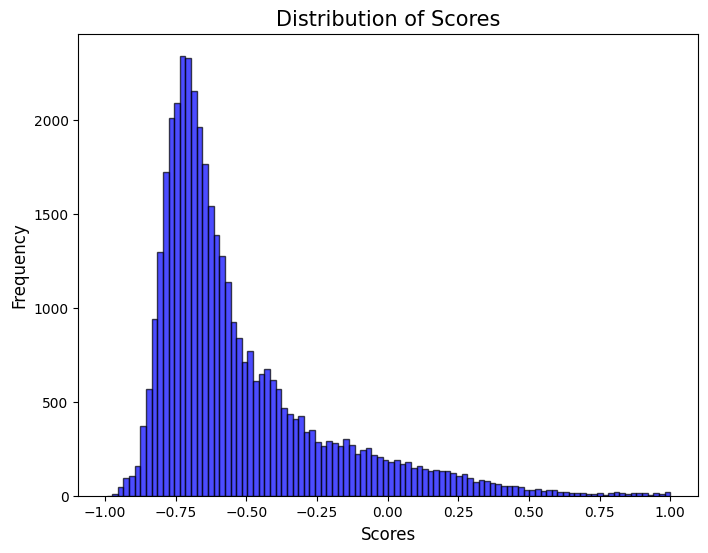

In [ ]:
import matplotlib.pyplot as plt
# 히스토그램 그리기
plt.figure(figsize=(8, 6))
plt.hist(scores, bins=100, color='blue', alpha=0.7, edgecolor='black')

# 그래프 제목과 축 레이블 설정
plt.title('Distribution of Scores', fontsize=15)
plt.xlabel('Scores', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
# 그래프 보여주기
plt.show()


In [ ]:
# 상위 5.8%에 해당하는 값 (94.2번째)
percentile_94_2 = np.percentile(scores, 94.2)

print("상위 5.8%의 끝에 있는 값:", percentile_94_2)

상위 5.8%의 끝에 있는 값: 0.09266434736549845


- 가중치 save

In [ ]:
path = 'C3.pkl'

In [ ]:
clf.save_model(path)

- 가중치 load

In [ ]:
clf_load = RoSAS.load_model(path)

# Test

In [ ]:
# test
test = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"), low_memory=False)
test_pre = preprocess_data(test)
test_X = test_pre.drop(columns=['Set ID'])

In [ ]:
# Stand
test_X.loc[:, test_X.columns.difference(binary_columns)] = scaler_stand.fit_transform(test_X.drop(columns=binary_columns))

In [ ]:
scores_test = clf.decision_function(test_X.values)

threshold = np.percentile(scores_test, 94.2)  # 상위 5.8%를 이상치로 간주
# threshold = 0
y_pred_test = (scores_test >= threshold).astype(int)

testing: 100%|██████████| 9/9 [00:00<00:00, 103.00it/s]


In [ ]:
# submission
submission = pd.read_csv(os.path.join("submission.csv"), low_memory=False)
submission["target"] = y_pred_test
submission['target'] = submission['target'].replace({0: 'Normal', 1: 'AbNormal'})

# 제출 파일 저장
submission.to_csv("submission.csv", index=False)

In [ ]:
submission

,Set ID,target
0,0001be084fbc4aaa9d921f39e595961b,Normal
1,0005bbd180064abd99e63f9ed3e1ac80,Normal
2,000948934c4140d883d670adcb609584,Normal
3,000a6bfd02874c6296dc7b2e9c5678a7,Normal
4,0018e78ce91343678716e2ea27a51c95,Normal
...,...,...
17356,ffea508b59934d689b540f95eb3fa730,Normal
17357,ffed8923c8a448a98afc641b770be153,Normal
17358,fff1e73734da40adbe805359b3efb462,Normal
17359,fff8e38bdd09470baf95f71e92075dec,Normal
